In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from time import time
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re

C:\Users\Tom\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting EDF parameters from Z:\PhD\Ryans Study\EEG\2_hard.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1413119  =      0.000 ...   690.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.00
- Lower transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 42.88 Hz)
- Upper passband edge: 51.00 Hz
- Upper transition bandwidth: 12.75 Hz (-6 dB cutoff frequency: 57.38 Hz)
- Filter length: 553 samples (0.270 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 67585 samples (33.000 sec)



[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.4s finished


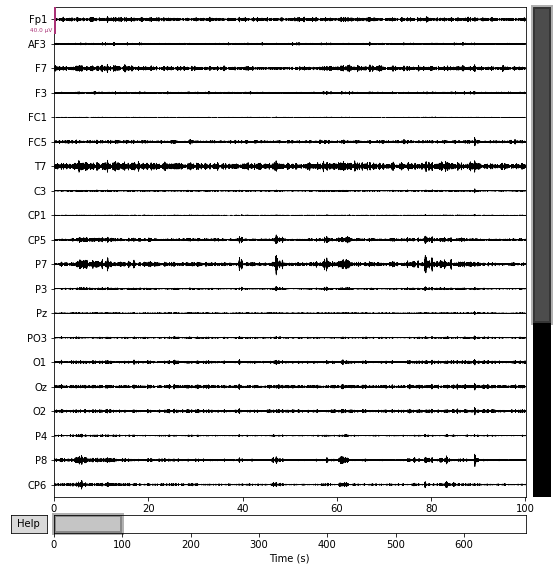

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 359.5s.


C:\Users\Tom\AppData\Local\Temp\ipykernel_23640\4027708629.py:12: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  label_components(raw, ica, method='iclabel')
C:\Users\Tom\AppData\Local\Temp\ipykernel_23640\4027708629.py:12: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(raw, ica, method='iclabel')
C:\Users\Tom\AppData\Local\Temp\ipykernel_23640\4027708629.py:12: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use t

{'y_pred_proba': array([0.43839014, 0.91572356, 0.566383  , 0.43254468, 0.5970146 ,
        0.7209888 , 0.86002797, 0.58013767, 0.944191  , 0.884478  ,
        0.3157661 , 0.7119229 , 0.6067183 , 0.4174615 , 0.9792106 ,
        0.5651245 , 0.74886465, 0.9680499 , 0.9048822 , 0.86370546,
        0.6739687 , 0.7458694 , 0.95994514, 0.5043885 , 0.8319495 ,
        0.67425257, 0.57438207, 0.4549958 , 0.4333393 , 0.4062447 ],
       dtype=float32),
 'labels': ['muscle artifact',
  'eye blink',
  'muscle artifact',
  'other',
  'other',
  'eye blink',
  'muscle artifact',
  'eye blink',
  'other',
  'muscle artifact',
  'channel noise',
  'other',
  'other',
  'eye blink',
  'eye blink',
  'other',
  'eye blink',
  'eye blink',
  'other',
  'other',
  'eye blink',
  'other',
  'eye blink',
  'other',
  'eye blink',
  'other',
  'other',
  'other',
  'eye blink',
  'eye blink']}

In [3]:
raw = mne.io.read_raw_bdf("../EEG/2_hard.bdf")
raw.load_data()
eeg_channels = mne.pick_types(raw.info)
raw.drop_channels(ch_names=["LEOG", "REOG","A1","A2","EXG7","EXG8",'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp', 'Status','Po4','UEOG', 'DEOG'])
raw = raw.notch_filter(50)
raw = raw.filter(0.1, 40.)
raw.set_montage(mne.channels.make_standard_montage('biosemi32'))
raw.plot(duration=100)
ica = ICA(n_components=31, max_iter=500000, random_state=69)
ica.fit(raw)
#ica.plot_components()
label_components(raw, ica, method='iclabel')
#dat = ica.apply(raw)
#dat.set_eeg_reference(ref_channels='Pz')
#dat.plot(duration=100)
